<a href="https://colab.research.google.com/github/maulik-vyas/Tensors-Fundamentals/blob/main/Transfer_Learning_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Mar 19 18:16:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()

--2023-03-19 18:16:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 209.85.234.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   129MB/s    in 1.2s    

2023-03-19 18:16:47 (129 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                             target_size=IMAGE_SHAPE,
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical')

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                           target_size=IMAGE_SHAPE,
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='categorical')

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
from keras.layers.attention.multi_head_attention import activation
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE + (3,))
  
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [9]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230319-181708
Epoch 1/5
24/24 [==============================] - 33s 848ms/step - loss: 1.9780 - accuracy: 0.3320 - val_loss: 1.2219 - val_accuracy: 0.6288
Epoch 2/5
24/24 [==============================] - 17s 734ms/step - loss: 0.8831 - accuracy: 0.7587 - val_loss: 0.8531 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 18s 756ms/step - loss: 0.6166 - accuracy: 0.8400 - val_loss: 0.7695 - val_accuracy: 0.7500
Epoch 4/5
24/24 [==============================] - 17s 750ms/step - loss: 0.4651 - accuracy: 0.8867 - val_loss: 0.7147 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3690 - accuracy: 0.9173 - val_loss: 0.6818 - val_accuracy: 0.7820


In [11]:
import matplotlib.pyplot as plt 
 
def plot_loss_curve(history):
   loss = history.history["loss"]
   val_loss = history.history["val_loss"]

   accuracy = history.history["accuracy"]
   val_accuracy = history.history["val_accuracy"]

   epochs = range(len(history.history["loss"]))

   plt.plot(epochs, loss, label="training_loss")
   plt.plot(epochs, val_loss, label="val_loss")
   plt.title("loss")
   plt.xlabel("epochs")
   plt.legend()

   plt.figure(),
   plt.plot(epochs, accuracy, label="training_accuracy")
   plt.plot(epochs, val_accuracy, label="val_accuracy")
   plt.title("accuracy")
   plt.xlabel("epochs")
   plt.legend();

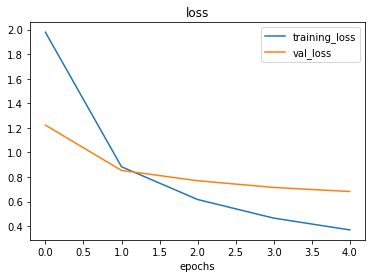

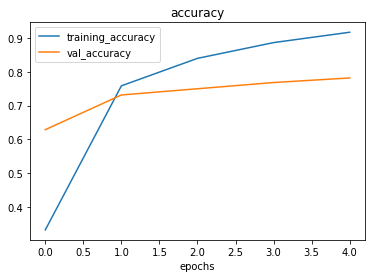

In [12]:
plot_loss_curve(resnet_history)

In [13]:
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [14]:
efficient_history = efficientnet_model.fit(train_data_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                  experiment_name="efficientnetb0"
                                                                                  )])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230319-181908
Epoch 1/5
24/24 [==============================] - 28s 775ms/step - loss: 1.8803 - accuracy: 0.4240 - val_loss: 1.3079 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 17s 733ms/step - loss: 1.0629 - accuracy: 0.7880 - val_loss: 0.8614 - val_accuracy: 0.8188
Epoch 3/5
24/24 [==============================] - 16s 693ms/step - loss: 0.7513 - accuracy: 0.8360 - val_loss: 0.6932 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 16s 695ms/step - loss: 0.6006 - accuracy: 0.8707 - val_loss: 0.6053 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 17s 744ms/step - loss: 0.5112 - accuracy: 0.8907 - val_loss: 0.5518 - val_accuracy: 0.8656


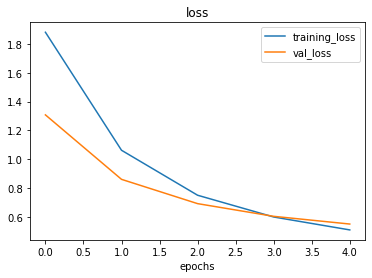

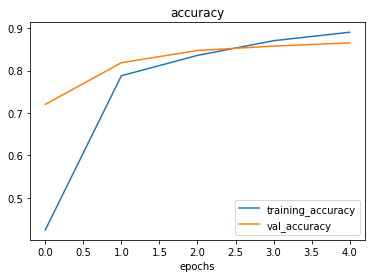

In [15]:
plot_loss_curve(efficient_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [18]:
len(efficientnet_model.layers[0].weights)

309

In [19]:
len(resnet_model.layers[0].weights)

270

In [21]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different feature extractor model" \
  --one_shot

2023-03-19 18:32:41.121705: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-19 18:32:41.121836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-19 18:32:41.121857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoar